In [351]:
import pandas as pd
import plotly.graph_objects as go
import plotly.subplots as sp
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import pickle


In [352]:
df = pd.read_csv('https://raw.githubusercontent.com/diegodio/LH_CD_DIEGODEDIO/main/teste_indicium_precificacao.csv')

In [353]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


# Descrição das features

id – Atua como uma chave exclusiva para cada anúncio nos dados do aplicativo

nome - Representa o nome do anúncio

host_id - Representa o id do usuário que hospedou o anúncio

host_name – Contém o nome do usuário que hospedou o anúncio

bairro_group - Contém o nome do bairro onde o anúncio está localizado

bairro - Contém o nome da área onde o anúncio está localizado

latitude - Contém a latitude do local

longitude - Contém a longitude do local

room_type – Contém o tipo de espaço de cada anúncio

price - Contém o preço por noite em dólares listado pelo anfitrião

minimo_noites - Contém o número mínimo de noites que o usuário deve reservar

numero_de_reviews - Contém o número de comentários dados a cada listagem

ultima_review - Contém a data da última revisão dada à listagem

reviews_por_mes - Contém o número de avaliações fornecidas por mês

calculado_host_listings_count - Contém a quantidade de listagem por host

disponibilidade_365 - Contém o número de dias em que o anúncio está disponível para reserva

# Conhecendo o dataset

In [177]:
#Quantidade de anúncios e features no dataset.
df.shape

(48894, 16)

In [178]:
#Conferindo se existe algum anúncio duplicado.
if sum(df.duplicated(df.columns)) == 0:
  print('Nenhum anúncio duplicado.')
else:
  print('Nenhum anúncio duplicado.')

Nenhum anúncio duplicado.


In [179]:
#Lista de features e o tipo de cada uma. Temos 10 features numéricas e 6 features categóricas.
#Percebemos algumas ausências nas featues nome, host_name, ultima_review e reviews_por_mes.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

# Valores faltantes

In [180]:
#Contando os valores ausentes em cada coluna.
print(df.isnull().sum())

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


In [181]:
#Quantidade de valores ausentes em porcentagem.
print(100*df.isnull().sum()/df.shape[0])

id                                0.000000
nome                              0.032724
host_id                           0.000000
host_name                         0.042950
bairro_group                      0.000000
bairro                            0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimo_noites                     0.000000
numero_de_reviews                 0.000000
ultima_review                    20.558760
reviews_por_mes                  20.558760
calculado_host_listings_count     0.000000
disponibilidade_365               0.000000
dtype: float64


-> 16 anúncios (0,03% do dataset) não possuem nome.

-> 21 anúncios (0,04% do dataset) não possuem host_name.

-> 10052 anúncios (20,55% do dataset) não possuem data da última review e nem a média de reviews por mês.



Os valores ausentes de nome e host_name são percentualmente baixos, 0.03% e 0.04%, respectivamente. Podemos preenchê-los sem alteração significativa no dataset.

In [182]:
#Preenchendo os nomes ausentes com o tipo de quarto, o bairro e o grupo do bairro.
df['nome'].fillna(f'{df["room_type"]} at {df["bairro"]} - {df["bairro_group"]}', inplace = True)

In [183]:
#Preenchendo os host_names ausentes.
#Alguns hosts possuem mais de um imóvel anunciado, a partir do host_id podemos tentar preencher o host_name caso esse apareça em algum outro anúncio.
df_sem_host_name = df[df['host_name'].isnull() == True]

id_conferidos = []
for row in df_sem_host_name.itertuples():
  if row.calculado_host_listings_count	> 1 and row.host_id not in id_conferidos: #Se existe mais de um anúncio do mesmo host_id, talvez algum tenha o host_name.
    df_id_selecionado = df_sem_host_name[df_sem_host_name['host_id'] == row.host_id] #df com o host_id repetido.
    if len(df_id_selecionado) > len(df_id_selecionado[df_id_selecionado['host_name'].isnull()]):
      print(f'O host de id ({row.host_id}) tem seu nome em ao menos 1 anúncio.')
    else:
      print(f'O host de id ({row.host_id}) não tem seu nome em nenhum anúncio.')
    id_conferidos.append(row.host_id)

O host de id (32722063) não tem seu nome em nenhum anúncio.
O host de id (159156636) não tem seu nome em nenhum anúncio.


Os hosts com id (32722063) e (159156636) são os únicos hosts que não tem o host_name e possuem mais de um imóvel anunciado. Porém, mesmo nos outros anúncios do mesmo host, não conseguimos encontrar o host_name. Não foi possível preencher nenhum host_name faltante dessa forma.

In [184]:
#Preenchemos então os host_names ausentes com o host_id.
df['host_name'].fillna(df['host_id'], inplace = True)

In [185]:
#Verificando se onde ultima_review está faltando é porque não existe reviews ainda.
if (df[df['ultima_review'].isnull()]['numero_de_reviews'] == 0).sum() == df['ultima_review'].isnull().sum():
  #Assim podemos preencher ultima_review com zero.
  df['ultima_review'].fillna('0000-00-00', inplace = True)

In [186]:
#Verificando se onde reviews_por_mes está faltando é porque não existe reviews ainda.
if (df[df['reviews_por_mes'].isnull()]['numero_de_reviews'] == 0).sum() == df['reviews_por_mes'].isnull().sum():
  #Assim podemos preencher reviews_por_mes com zero.
  df['reviews_por_mes'].fillna(0, inplace = True)

In [187]:
#Nenhum valor ausente.
df.isnull().sum()

id                               0
nome                             0
host_id                          0
host_name                        0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
ultima_review                    0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

In [188]:
#Se a disponibilidade_365 é igual 0, seja por opção ou não do host, temos um anúncio de um imóvel que não pode ser alugado.
#Vamos selecionar apenas os anúncios com disponibilidade_365 > 0.
df = df[~(df['disponibilidade_365'] == 0)]

In [189]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0000-00-00,0.00,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220


# Análise exploratória de dados (EDA)

## Sobre os bairros

In [190]:
num_bairro_group = df['bairro_group'].nunique()
list_bairro_group = df['bairro_group'].unique()

print(f'Nova York possui {num_bairro_group} grupos de bairros, chamados de "borough". Sao eles: {list_bairro_group}')

Nova York possui 5 grupos de bairros, chamados de "borough". Sao eles: ['Manhattan' 'Brooklyn' 'Queens' 'Staten Island' 'Bronx']


In [191]:
for borough, num_bairros in zip(df.groupby('bairro_group')['bairro'].nunique().index,df.groupby('bairro_group')['bairro'].nunique().values):
  print(f'O grupo de bairros {borough} é formado por {num_bairros} bairros.')

O grupo de bairros Bronx é formado por 48 bairros.
O grupo de bairros Brooklyn é formado por 47 bairros.
O grupo de bairros Manhattan é formado por 32 bairros.
O grupo de bairros Queens é formado por 51 bairros.
O grupo de bairros Staten Island é formado por 40 bairros.


## Sobre os anúncios

In [192]:
x = df['bairro_group'].value_counts().index
y = df['bairro_group'].value_counts().values

fig = go.Figure(data=go.Bar(x=x, y=y))

for i in range(len(x)):
    fig.add_annotation(
        x=x[i],
        y=y[i],
        text=str(y[i]),
        showarrow=False,
        font=dict(
            size=14,
            color="black"
        ),
        align="center",
        yshift=10
    )

fig.update_layout(title_text='Anúncios em cada grupo de bairros')
fig.update_xaxes(title_text='Grupo de bairros')
fig.update_yaxes(title_text='Quantidade de anúncios')

fig.show()

In [193]:
#Gráfico dos 50 bairros com maior número de imóveis anunciados.
x = df['bairro'].value_counts().index[:30]
y = df['bairro'].value_counts().values[:30]

cores = df['bairro_group'].replace({'Manhattan': '#1f77b4', 'Brooklyn': '#ff7f0e', 'Queens': '#2ca02c', 'Staten Island': '#d62728', 'Bronx': '#9467bd'})


fig = go.Figure(data=go.Bar(x=x, y=y, marker_color=cores))

fig.update_layout(title_text='50 bairros com maior número de imóveis anunciados', showlegend=False)
fig.update_xaxes(title_text='Bairro')
fig.update_yaxes(title_text='Quantidade de anúncios')

fig.show()

Vemos a partir desses gráficos que os grupos de bairros Manhattan e Brooklyn são os que possuem mais anúncios, e possuem juntos todos os 30 bairros com mais anúncios em Nova York.

Sendo os dois bairros com mais anúncios, Bedford-Stuyvesant e Williamsburg, localizados no Brooklyn e o terceiro, Harlem, em Manhattan.

Manhattan possui apenas 2 bairros entre os 10 com mais anúncios, Harlem em 3º e East Village em 9º.

In [194]:
fig = sp.make_subplots(rows=3, cols=2, subplot_titles=df['bairro_group'].unique(), vertical_spacing=0.3)

i = 1
j = 1
for bairro in df['bairro_group'].unique():
  df_cut = df[df['bairro_group'] == bairro]

  grafico = go.Bar(x=df_cut['bairro'].value_counts().index, y=df_cut['bairro'].value_counts().values, name=bairro)

  if i == 3:
    i = 1
    j += 1

  fig.add_trace(grafico, row=j, col=i)
  i += 1


fig.update_yaxes(title_text='Quantidade anúncios')
# fig.update_xaxes(title_text='Bairro')

fig.update_layout(height=800, width=1300, title_text="Quantidade anúncios em cada bairro de cada grupo de bairros", showlegend=False)


fig.show()

O bairro com mais anúncios em Manhattan é o Harlem.

O bairro com mais anúncios em Brooklyn é o Bedford-Stuyvesant.

O bairro com mais anúncios em Queens é o Astoria.

O bairro com mais anúncios em State Island é o St. George.

O bairro com mais anúncios em Bronx é o Kingsbridge.

## Sobre os preços

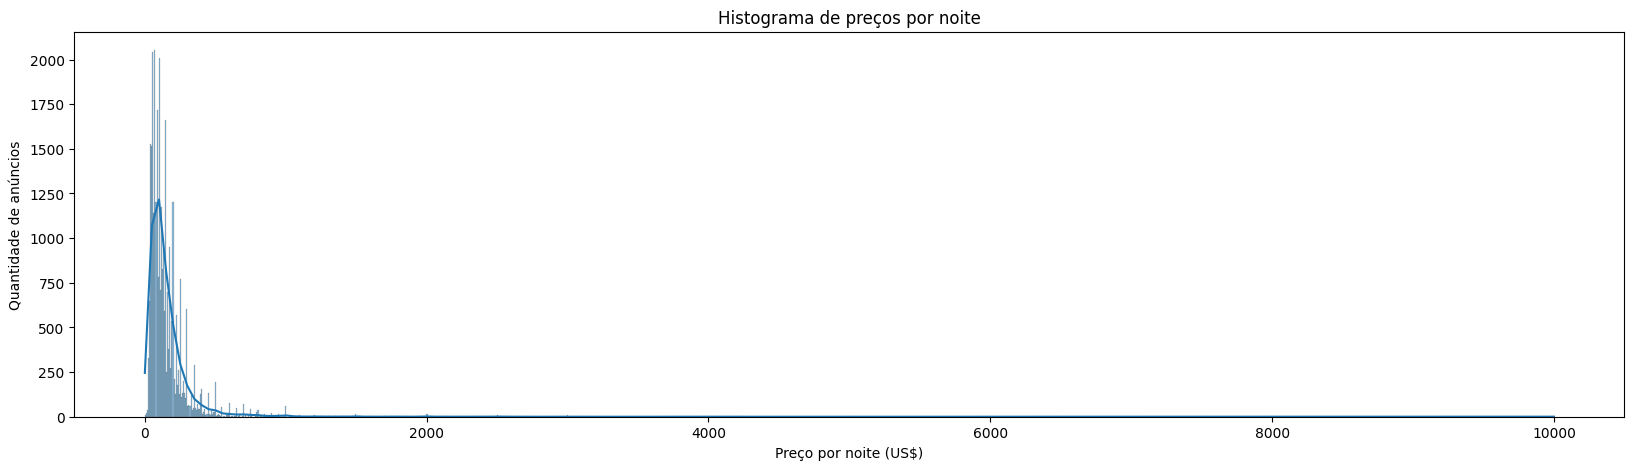

In [195]:
plt.figure(figsize=(20, 5))
plt.title("Histograma de preços por noite")
sns.histplot(df['price'], kde=True)
plt.xlabel("Preço por noite (US$)")
plt.ylabel("Quantidade de anúncios")
plt.show()

In [196]:
print(f'''
Os preços por noite acima de US$800 correspondem a aproximadamente {100*df[df["price"] > 800].shape[0]/df["price"].shape[0]:.2f}% dos anúncios, visualizamos melhor a distribuição sem eles.
''')


Os preços por noite acima de US$800 correspondem a aproximadamente 1.01% dos anúncios, visualizamos melhor a distribuição sem eles.



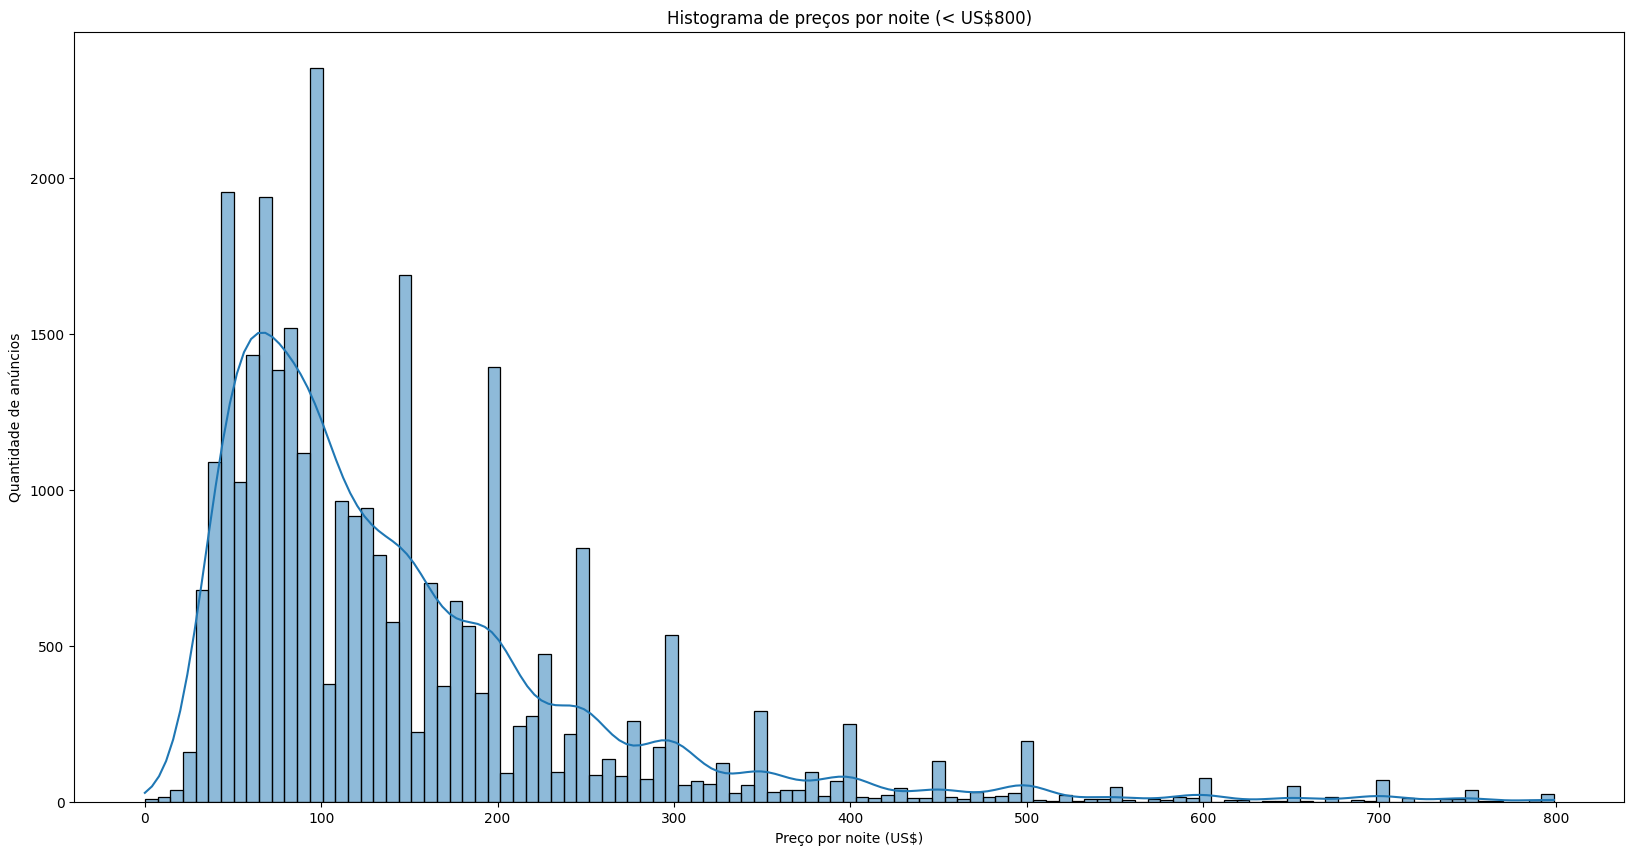

In [197]:
plt.figure(figsize=(20, 10))
plt.title("Histograma de preços por noite (< US$800)")
sns.histplot(df[df['price'] < 800]['price'], kde=True)
plt.xlabel("Preço por noite (US$)")
plt.ylabel("Quantidade de anúncios")
plt.show()

In [198]:
print('''
O preço por noite mais comum é em torno de US$100.
''')


O preço por noite mais comum é em torno de US$100.



In [199]:
print(f'''
Os preços por noite acima até US$200 correspondem a aproximadamente {100*df[df["price"] <= 200].shape[0]/df["price"].shape[0]:.2f}% dos anúncios, visualizamos melhor a distribuição sem eles.
''')


Os preços por noite acima até US$200 correspondem a aproximadamente 80.33% dos anúncios, visualizamos melhor a distribuição sem eles.



In [200]:
print('''
Existe, entre os hosts, uma tendência em fazer anúncios com números múltiplos de 50, e.g., 100, 150, 200, 250, 300, 350... 800.
O mesmo acontece, em menor escala, para os múltiplos de 15 que não são múltiplos de 50, e.g., 75, 125, 175...
      ''')


Existe, entre os hosts, uma tendência em fazer anúncios com números múltiplos de 50, e.g., 100, 150, 200, 250, 300, 350... 800. 
O mesmo acontece, em menor escala, para os múltiplos de 15 que não são múltiplos de 50, e.g., 75, 125, 175...
      


In [201]:
fig = sp.make_subplots(rows=3, cols=2, subplot_titles=df['bairro_group'].unique(), vertical_spacing=0.3)

i = 1
j = 1

for bairro in df['bairro_group'].unique():
  df_cut = df[df['bairro_group'] == bairro]

  dic = {
    'regiao': [],
    'preco_medio': [],
  }

  for regiao in df_cut['bairro'].unique():
    dic['regiao'].append(regiao)
    dic['preco_medio'].append(df_cut[df_cut['bairro'] == regiao]['price'].mean())


  df_reg_media_preco = pd.DataFrame(dic)

  grafico = go.Bar(x=df_reg_media_preco['regiao'], y=df_reg_media_preco['preco_medio'], name=bairro)

  # print(f'''{bairro.upper()}
  #       Maior preço médio é no bairro {df_reg_media_preco["regiao"].loc[df_reg_media_preco["preco_medio"].idxmax()]} (US${df_reg_media_preco["preco_medio"].max():.2f}).
  #       Menor preço médio é no bairro {df_reg_media_preco["regiao"].loc[df_reg_media_preco["preco_medio"].idxmin()]} (US${df_reg_media_preco["preco_medio"].min():.2f}).
  #       ''')

  if i == 3:
    i = 1
    j += 1

  fig.add_trace(grafico, row=j, col=i)
  i += 1

fig.update_layout(height=800, width=1700, title_text="Preço médio dos imóveis em cada bairro de cada grupo de bairros", showlegend=False)
fig.update_yaxes(title_text='Preço médio por noite(US$)')

fig.show()

MANHATTAN

        Maior preço médio é no bairro Tribeca (US$561.46).
        Menor preço médio é no bairro Inwood (US$94.26).
        
BROOKLYN

        Maior preço médio é no bairro Sea Gate (US$569.67).
        Menor preço médio é no bairro Borough Park (US$65.35).
        
QUEENS

        Maior preço médio é no bairro Neponsit (US$274.67).
        Menor preço médio é no bairro Corona (US$58.73).
        
STATEN ISLAND

        Maior preço médio é no bairro Fort Wadsworth (US$800.00).
        Menor preço médio é no bairro Port Richmond (US$48.80).
        
BRONX

        Maior preço médio é no bairro Riverdale (US$567.25).
        Menor preço médio é no bairro Mount Eden (US$42.67).

In [202]:
y = df.groupby('bairro')['price'].mean().sort_index().sort_values(ascending=False)
x = y.index

fig = go.Figure(data=go.Bar(x=x[:15], y=y[:15]))

for i in range(len(x[:15])):
    fig.add_annotation(
        x=x[i],
        y=y[i],
        text= 'US$' + str(int(y[i])),
        showarrow=False,
        font=dict(
            size=14,
            color="black"
        ),
        align="center",
        yshift=10
    )

fig.update_layout(title_text='15 bairros mais caros')
fig.update_xaxes(title_text='Bairro')
fig.update_yaxes(title_text='Preço médio por noite(US$)')

fig.show()

Apesar de Fort Wadsworth aparecer com o maior preço médio por noite, esse valor corresponde a apenas um imóvel. Esse valor pode ser irreal e não deve ser considerado com o peso de uma média.

Sea Gate, Riverdale e Tribeca são os bairros mais caros, com preço médio por noite de 569, 567 e 561 dolares, respectivamente. São também as maiores médias do Brooklyn, Bronx e Manhattan, nessa ordem.

In [203]:
y = df.groupby('bairro_group')['price'].mean().sort_index().sort_values(ascending=False)
x = y.index

fig = go.Figure(data=go.Bar(x=x, y=y, marker_color=['#1f77b4','#ff7f0e', '#2ca02c', '#d62728', '#9467bd']))

for i in range(len(x)):
    fig.add_annotation(
        x=x[i],
        y=y[i],
        text= 'US$' + str(int(y[i])),
        showarrow=False,
        font=dict(
            size=14,
            color="black"
        ),
        align="center",
        yshift=10
    )

fig.update_layout(title_text='Preço médio em cada grupo de bairro')
fig.update_xaxes(title_text='Grupo de bairros')
fig.update_yaxes(title_text='Preço médio por noite (US$)')

fig.show()

Manhattan possui o preço médio por noite mais caro de Nova York, seguido por Brooklyn, Staten Island, Queens e Bronx.

O preço médio por noite em Manhattan é, aproximadamente, o dobro do preço em Staten Island, Queens e Bronx. E é 62% maior que o preço no Brooklyn, o segundo colocado.

In [204]:
x = df.groupby('room_type')['price'].mean().sort_values(ascending=False).index
y = df.groupby('room_type')['price'].mean().sort_values(ascending=False).values

fig = go.Figure(data=go.Bar(x=x, y=y, marker_color=['#1f77b4','#ff7f0e', '#2ca02c']))
fig.update_layout(title='Preço médio por noite para cada tipo de imóvel',
                  xaxis_title='Tipo de imóvel',
                  yaxis_title='Preço médio por noite (US$)')
fig.show()

Como o esperado, o preço médio por noite de uma casa/apartamento completo é maior (mais de 2x maior) que o de um quarto privado ou compartilhado.

## Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

In [205]:
med_preco_bairro = df.groupby('bairro')['price'].mean()
num_anuncios_bairro = df['bairro'].value_counts().sort_index()

In [206]:
df_med_preco_bairro = pd.DataFrame(med_preco_bairro)
df_num_anuncios_bairro = pd.DataFrame(num_anuncios_bairro)

In [207]:
df_resultado = pd.concat([df_med_preco_bairro, df_num_anuncios_bairro], axis=1)

In [208]:
df_resultado.rename(columns={'price': 'med_price', 'bairro': 'num_anuncios'}, inplace=True)
df_resultado['razao_med_preco_num_anuncios'] = df_resultado['med_price']/df_resultado['num_anuncios']
df_resultado['indice'] = df_resultado.index
df_resultado

,med_price,num_anuncios,razao_med_preco_num_anuncios,indice
Allerton,91.702703,37,2.478451,Allerton
Arden Heights,76.000000,3,25.333333,Arden Heights
Arrochar,115.000000,21,5.476190,Arrochar
Arverne,175.095890,73,2.398574,Arverne
Astoria,110.476277,548,0.201599,Astoria
...,...,...,...,...
Willowbrook,249.000000,1,249.000000,Willowbrook
Windsor Terrace,142.397849,93,1.531160,Windsor Terrace
Woodhaven,66.544304,79,0.842333,Woodhaven
Woodlawn,60.111111,9,6.679012,Woodlawn


In [209]:
#Tiramos bairros abaixo da média de anúncios por serem pouco desejados ou pouco popular.
df_resultado = df_resultado[df_resultado['num_anuncios'] > df_resultado['num_anuncios'].mean()]

In [210]:
fig = px.scatter(df_resultado, x='indice', y='razao_med_preco_num_anuncios')

fig.update_xaxes(title_text='Bairro')
fig.update_yaxes(title_text='Razão entre preço médio por noite e número de anúncios')

fig.show()

**Resposta abaixo**

In [211]:
print(f'''
A compra mais indicada seria em Greenwich Village, pois tem a melhor razão entre preço médio por noite e número de anúncios.
Preço médio -> US${df_resultado.loc[df_resultado['indice'] == 'Greenwich Village', 'med_price'].values[0]:.2f}
Número de anúncios -> {df_resultado.loc[df_resultado['indice'] == 'Greenwich Village', 'num_anuncios'].values[0]}
''')
print('_____________________________________________________________________________________________________________________________')
print('Outras indicações')
print(f'''
Outra compra indicada indicada seria em SoHo, pois tem uma boa razão entre preço médio por noite e número de anúncios.
Preço médio -> US${df_resultado.loc[df_resultado['indice'] == 'SoHo', 'med_price'].values[0]:.2f}
Número de anúncios -> {df_resultado.loc[df_resultado['indice'] == 'SoHo', 'num_anuncios'].values[0]}
''')
print(f'''
Outra compra indicada seria em Gramercy, pois tem uma boa razão entre preço médio por noite e número de anúncios.
Preço médio -> US${df_resultado.loc[df_resultado['indice'] == 'Gramercy', 'med_price'].values[0]:.2f}
Número de anúncios -> {df_resultado.loc[df_resultado['indice'] == 'Gramercy', 'num_anuncios'].values[0]}
''')


A compra mais indicada seria em Greenwich Village, pois tem a melhor razão entre preço médio por noite e número de anúncios.
Preço médio -> US$282.49
Número de anúncios -> 207

_____________________________________________________________________________________________________________________________
Outras indicações

Outra compra indicada indicada seria em SoHo, pois tem uma boa razão entre preço médio por noite e número de anúncios.
Preço médio -> US$319.40
Número de anúncios -> 244


Outra compra indicada seria em Gramercy, pois tem uma boa razão entre preço médio por noite e número de anúncios.
Preço médio -> US$247.90
Número de anúncios -> 196



## O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

### Mínimo de noites

In [212]:
df_med_preco = df.groupby('minimo_noites')['price'].mean().sort_values(ascending=False)

In [213]:
df_min_noites = pd.DataFrame(df_med_preco.index)
df_med_preco = pd.DataFrame(df_med_preco.values)

In [214]:
df_resultado = pd.concat([df_min_noites, df_med_preco], axis=1)

In [215]:
df_resultado.columns

Index(['minimo_noites', 0], dtype='object')

In [216]:
df_resultado.rename(columns={0: 'preco_med'}, inplace=True)

In [217]:
df_resultado_1_mes = df_resultado[df_resultado['minimo_noites'] <= 30 ]

In [218]:
fig = px.scatter(df_resultado_1_mes, x='minimo_noites', y='preco_med')

fig.update_xaxes(title_text='Mínimo de noites')
fig.update_yaxes(title_text='Preço médio por noite (US$)')

fig.show()

A relação entre o mínimo de noites e o preço por noite parece ser senoidal, tendo seus máximos locais em torno dos múltiplos de cinco e seus mínimos locais próximos aos multiplos de 7 mais um dia (número de semanas +1 dia).

### Disponibilidade

In [219]:
df_med_preco = df.groupby('disponibilidade_365')['price'].mean().sort_values(ascending=False)

In [220]:
df_disponibilidade_365 = pd.DataFrame(df_med_preco.index)
df_med_preco = pd.DataFrame(df_med_preco.values)

In [221]:
df_resultado_disp = pd.concat([df_disponibilidade_365, df_med_preco], axis=1)

In [222]:
df_resultado_disp.columns

Index(['disponibilidade_365', 0], dtype='object')

In [223]:
df_resultado_disp.rename(columns={0: 'preco_med'}, inplace=True)

In [224]:
fig = px.scatter(df_resultado_disp, x='disponibilidade_365', y='preco_med')

fig.update_xaxes(title_text='Mínimo de noites')
fig.update_yaxes(title_text='Preço médio por noite (US$)')

fig.show()

Vemos uma **leve** tendência do preço médio por noite de aumentar com o aumento da disponibilidade. Isso mostra um interesse maior em alugar de quem não tem muita disponibilidade, enquanto o host que tem mais disponibilidade não se preocupa tanto em diminuir o preço.

### Texto do nome

In [226]:
#Valores acima de 200 dólares contabilizam ~20% do dataset.
df_mais_200 = df[df['price'] > 200]
df_menos_200 = df[df['price'] <= 200]

In [227]:
lista_mais_200 = list(df_mais_200['nome'])
lista_menos_200 = list(df_menos_200['nome'])

In [228]:
nova_lista_mais_200 = []
for item in lista_mais_200:
  nova_lista_mais_200.append(item.split(' '))

lista_final_mais_200 = []
for item in nova_lista_mais_200:
  lista_final_mais_200.extend(item)

lista_final_minuscula_mais_200 = [item.lower() for item in lista_final_mais_200]

nova_lista_menos_200 = []
for item in lista_menos_200:
  nova_lista_menos_200.append(item.split(' '))

lista_final_menos_200 = []
for item in nova_lista_menos_200:
  lista_final_menos_200.extend(item)

lista_final_minuscula_menos_200 = [item.lower() for item in lista_final_menos_200]

In [229]:
df_final_mais_200 = pd.DataFrame(lista_final_minuscula_mais_200, columns=['palavras'])
df_final_menos_200 = pd.DataFrame(lista_final_minuscula_menos_200, columns=['palavras'])

In [230]:
lista_palavras_mais_200 = []
for item in df_final_mais_200.value_counts().index:
  lista_palavras_mais_200.append(item[0])

lista_palavras_menos_200 = []
for item in df_final_menos_200.value_counts().index:
  lista_palavras_menos_200.append(item[0])

In [231]:
df_palavras_mais_200 = pd.DataFrame({'palavras': lista_palavras_mais_200, 'quantidade': df_final_mais_200.value_counts().values})
df_palavras_menos_200 = pd.DataFrame({'palavras': lista_palavras_menos_200, 'quantidade': df_final_menos_200.value_counts().values})

In [232]:
df_palavras_mais_200.loc[:30]

,palavras,quantidade
0,in,1509
1,2,841
2,bedroom,792
3,apartment,671
4,|,592
5,,567
6,the,539
7,luxury,515
8,+,498
9,apt,492


In [233]:
df_palavras_menos_200.loc[:30]

,palavras,quantidade
0,in,8038
1,room,5636
2,private,4271
3,bedroom,3431
4,apartment,2796
5,cozy,2659
6,to,2498
7,,2045
8,brooklyn,1957
9,the,1956


Retirando as *stopwords*, as 15 palavras mais utilizadas pelos anúncios mais caros (acima de US$200, ~20% do dataset) são: bedroom, apartment, luxury, loft, east, park, village, studio, manhattan, central.

Retirando as *stopwords*, as 15 palavras mais utilizadas pelos anúncios mais baratos (abaixo de US$200, ~80% do dataset) são: room, private, bedroom, apartment, cozy, brooklyn, studio, manhattan, spacious, near.

Entre as 10 palavras mais utilizadas para os anúncios mais caros, 7 são *stopwords*, para os mais baratos, apenas 4.

#3 - Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

## Preprocessamento

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31361 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             31361 non-null  int64  
 1   nome                           31361 non-null  object 
 2   host_id                        31361 non-null  int64  
 3   host_name                      31361 non-null  object 
 4   bairro_group                   31361 non-null  object 
 5   bairro                         31361 non-null  object 
 6   latitude                       31361 non-null  float64
 7   longitude                      31361 non-null  float64
 8   room_type                      31361 non-null  object 
 9   price                          31361 non-null  int64  
 10  minimo_noites                  31361 non-null  int64  
 11  numero_de_reviews              31361 non-null  int64  
 12  ultima_review                  31361 non-null 

In [316]:
def pre_processamento(df):
  #room_type é uma feature categórica ordinal, pois existe uma classificação intrínseca.
  df.loc[df['room_type'] == 'Entire home/apt', 'room_type'] = 3
  df.loc[df['room_type'] == 'Private room', 'room_type'] = 2
  df.loc[df['room_type'] == 'Shared room', 'room_type'] = 1
  df['room_type'] = df['room_type'].astype(int)

  #Drop das features categóricas e features que não vão contribuir para o modelo.
  #latitude, longitude, bairro e bairro_group carregam basicamente a mesma informação, manteremos apenas bairro_group.
  #A data da ultima_review não tem relação com o preço por noite do imóvel.
  df = df.drop(['id', 'nome', 'host_id', 'host_name', 'ultima_review', 'latitude', 'longitude', 'bairro'], axis=1)

  #OneHot encode da feature bairro_group, transformando-a em outras 5 features binárias.
  df = pd.get_dummies(df, columns=['bairro_group'])

  #Retirando valores de preço = 0.
  df = df[~(df['price'] == 0)]

  #Adicionando um pequeno valor para evitar log(0).
  #E fazendo uma transformada logarítmica.
  df.minimo_noites += 0.000000001
  df['minimo_noites'] = np.log10(df['minimo_noites'])
  df.numero_de_reviews += 0.000000001
  df['numero_de_reviews'] = np.log10(df['numero_de_reviews'])
  df.reviews_por_mes += 0.000000001
  df['reviews_por_mes'] = np.log10(df['reviews_por_mes'])
  df.calculado_host_listings_count += 0.000000001
  df['calculado_host_listings_count'] = np.log10(df['calculado_host_listings_count'])
  df.disponibilidade_365 += 0.000000001
  df['disponibilidade_365'] = np.log10(df['disponibilidade_365'])
  df.price += 0.000000001
  df['price'] = np.log10(df['price'])
  df['room_type'] = np.log10(df['room_type'])

  return df

def pre_processamento_amostra(df):
  #room_type é uma feature categórica ordinal, pois existe uma classificação intrínseca.
  df.loc[df['room_type'] == 'Entire home/apt', 'room_type'] = 3
  df.loc[df['room_type'] == 'Private room', 'room_type'] = 2
  df.loc[df['room_type'] == 'Shared room', 'room_type'] = 1
  df['room_type'] = df['room_type'].astype(int)

  #Drop das features categóricas e features que não vão contribuir para o modelo.
  #latitude, longitude, bairro e bairro_group carregam basicamente a mesma informação, manteremos apenas bairro_group.
  #A data da ultima_review não tem relação com o preço por noite do imóvel.
  df = df.drop(['id', 'nome', 'host_id', 'host_name', 'ultima_review', 'latitude', 'longitude', 'bairro', 'bairro_group'], axis=1)

  # #OneHot encode da feature bairro_group, transformando-a em outras 5 features binárias.
  # df = pd.get_dummies(df, columns=['bairro_group'])

  df['bairro_group_Bronx'] = 0
  df['bairro_group_Brooklyn'] = 0
  df['bairro_group_Manhattan'] = 1
  df['bairro_group_Queens'] = 0
  df['bairro_group_Staten Island'] = 0

  #Retirando valores de preço = 0.
  df = df[~(df['price'] == 0)]

  #Adicionando um pequeno valor para evitar log(0).
  #E fazendo uma transformada logarítmica.
  df.minimo_noites += 0.000000001
  df['minimo_noites'] = np.log10(df['minimo_noites'])
  df.numero_de_reviews += 0.000000001
  df['numero_de_reviews'] = np.log10(df['numero_de_reviews'])
  df.reviews_por_mes += 0.000000001
  df['reviews_por_mes'] = np.log10(df['reviews_por_mes'])
  df.calculado_host_listings_count += 0.000000001
  df['calculado_host_listings_count'] = np.log10(df['calculado_host_listings_count'])
  df.disponibilidade_365 += 0.000000001
  df['disponibilidade_365'] = np.log10(df['disponibilidade_365'])
  df.price += 0.000000001
  df['price'] = np.log10(df['price'])
  df['room_type'] = np.log10(df['room_type'])

  return df

Quais variáveis e/ou suas transformações você utilizou e por quê?

- Vamos usar as variáveis:

    'room_type', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365', 'bairro_group'.

- Retiramos as variáveis que não possuem relação com o preço por noite do imóvel:

    'id', 'nome', 'host_id', 'host_name', 'ultima_review'

- As variáveis latitude, longitude, bairro e bairro_group carregam basicamente a mesma informação, manteremos apenas bairro_group.

## Modelagem

Qual tipo de problema estamos resolvendo (regressão, classificação)?

- Trate-se de um problema de regressão, pois procuramos como resposta um valor numérico específico.

Qual modelo melhor se aproxima dos dados e quais seus prós e contras?

- Vamos testar 3 modelos: regressão linear, random forest regressor e XGBoost.

In [252]:
df_preprocessado = pre_processamento(df)

In [253]:
X = df_preprocessado.drop("price", axis=1)
y = df_preprocessado["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Regressão Linear

In [254]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [260]:
print('Resultados da Regressão Linear')
print('')
print('Avaliação nos dados de treinamento')
print('R2: ',np.round(r2_score(y_train, lr.predict(X_train)),2))
print('MSE: ', np.round(mean_squared_error(y_train,lr.predict(X_train)),2))
print('MAE: ', np.round(mean_absolute_error(y_train,lr.predict(X_train)),2))
print('----------------------------------------')
print('Avaliação nos dados de teste')
print('R2: ',np.round(r2_score(y_test, lr.predict(X_test)),2))
print('MSE: ', np.round(mean_squared_error(y_test,lr.predict(X_test)),2))
print('MAE: ', np.round(mean_absolute_error(y_test,lr.predict(X_test)),2))

Resultados da Regressão Linear

Avaliação nos dados de treinamento
R2:  0.48
MSE:  0.05
MAE:  0.17
----------------------------------------
Avaliação nos dados de teste
R2:  0.46
MSE:  0.05
MAE:  0.17


### Random Forest Regressor

In [341]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [342]:
print('Resultados do Random Forest Regressor')
print('')
print('Avaliação nos dados de treinamento')
print('R2: ',np.round(r2_score(y_train, rfr.predict(X_train)),2))
print('MSE: ', np.round(mean_squared_error(y_train,rfr.predict(X_train)),2))
print('MAE: ', np.round(mean_squared_error(y_train,rfr.predict(X_train)),2))
print('----------------------------------------')
print('Avaliação nos dados de teste')
print('R2: ',np.round(r2_score(y_test, rfr.predict(X_test)),2))
print('MSE: ', np.round(mean_squared_error(y_test,rfr.predict(X_test)),2))
print('MAE: ', np.round(mean_squared_error(y_test,rfr.predict(X_test)),2))

Resultados do Random Forest Regressor

Avaliação nos dados de treinamento
R2:  0.92
MSE:  0.01
MAE:  0.01
----------------------------------------
Avaliação nos dados de teste
R2:  0.53
MSE:  0.05
MAE:  0.05


### XGBoost

In [263]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.05,
    'n_estimators': 100
}

xg = xgb.train(params, dtrain, num_boost_round=params['n_estimators'])

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[01:00:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.




In [264]:
print('Resultados do XGBoost')
print('')
print('Avaliação nos dados de treinamento')
print('R2: ',np.round(r2_score(y_train, xg.predict(dtrain)),2))
print('MSE: ', np.round(mean_squared_error(y_train,xg.predict(dtrain)),2))
print('MAE: ', np.round(mean_absolute_error(y_train,xg.predict(dtrain)),2))
print('----------------------------------------')
print('Avaliação nos dados de teste')
print('R2: ',np.round(r2_score(y_test, xg.predict(dtest)),2))
print('MSE: ', np.round(mean_squared_error(y_test,xg.predict(dtest)),2))
print('MAE: ', np.round(mean_absolute_error(y_test,xg.predict(dtest)),2))

Resultados do XGBoost

Avaliação nos dados de treinamento
R2:  0.58
MSE:  0.04
MAE:  0.15
----------------------------------------
Avaliação nos dados de teste
R2:  0.55
MSE:  0.05
MAE:  0.15


## Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?


- As medidas escolhidas foram R2, MSE e MAE, porque com eles conseguimos avaliar o percentual da variância dos dados que é explicado pelo modelo e a relação do modelo com o erro, seja quadrático ou absoluto. Idealmente o R2 deve estar o mais próximo de 1 possível, enquando o MSE e MAE devem tender a zero.

- Usando esse critérios, o modelo de Random Forest Regressor foi o escolhido.

# Supondo um apartamento com as seguintes características:

{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'price': 225,
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

Qual seria a sua sugestão de preço?

In [343]:
amostra = pd.DataFrame({'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 3,
 'price': 225,
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}, index=[0])

X_amostra_preprocessada = pre_processamento_amostra(amostra)

y_amostra_preprocessada = X_amostra_preprocessada['price']
X_amostra_preprocessada = X_amostra_preprocessada.drop('price', axis=1)

In [344]:
preco_amostra = pd.DataFrame({'preco_verdadeiro': np.round(10 ** y_amostra_preprocessada, 0),
                   'preco_previsto': np.round(10 ** rfr.predict(X_amostra_preprocessada), 0)})
preco_amostra

,preco_verdadeiro,preco_previsto
0,225.0,227.0


In [345]:
print(f'''
A sugestão de preço por noite para esse imóvel é US${int(preco_amostra['preco_previsto'][0])}.
Esse valor é ~1% maior que o praticado atualmente.
''')


A sugestão de preço por noite para esse imóvel é US$227.
Esse valor é ~1% maior que o praticado atualmente.



# Salvando o modelo

In [346]:
with open('modelo.pkl', 'wb') as arquivo:
    pickle.dump(rfr, arquivo)